In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving csv_data_clean_names.csv to csv_data_clean_names.csv
User uploaded file "csv_data_clean_names.csv" with length 4264520 bytes


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import tensorflow as tf
from statsmodels.tsa.api import VAR
from google.colab import drive

drive.mount('drive')






Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
def wqms_prepare_data():
    df = pd.read_csv('csv_data_clean_names.csv', low_memory=False)
    df.columns = [c.replace(' ', '_') for c in df.columns]
    print("tüm veri:", df.shape)
    akarsu_df = df.loc[df['Table_Type'] == 'Akarsu']
    print("akarsu verisi:",akarsu_df.shape)
    # Display missing data
    missing = akarsu_df.isna().sum()
    #print("NA veri sayısı:", missing)
    missing_perc = missing / len(df)
    m = pd.DataFrame(missing)
    m_perc = pd.DataFrame(missing_perc)
    m_df = pd.concat([m, m_perc], axis=1)
    m_df = m_df.rename(columns={0: 'Total'})
    print("NA veri sayısı ve yüzdesi: ",m_df)
    # Akarsu istatistiğini HandleMissingData_akarsu.ipynb den çek
    akarsu_rel = akarsu_df.drop(
        ['Amonyak', 'Debi_(Gün)', 'Fekal_Streptokok', 'Toplam_Azot', 'Toplam_Fenol', 'Işık_Geçirgenliği', 'Nitrat',
         'Klorofil', 'Yağ', 'Açıklama', 'Renk', 'Koku', 'Renk_/_Koku'], axis='columns')
    akarsu_rel = akarsu_rel.drop(
        ['Toplam_Çözünmüş_Madde', 'Debi_(Saniye)', 'Orto_Fosfat', 'Biyokimyasal_Oksijen_İhtiyacı', 'Tarih'], axis='columns')
    print("preprocessing sonrası akarsu:",akarsu_rel.shape)
    #print(akarsu_rel.describe)
    print(akarsu_rel.shape)

    for column in akarsu_rel:
      akarsu_rel[column].interpolate(inplace = True)
    missingr_akarsu = akarsu_rel.isna().sum()
    mr_akarsu = pd.DataFrame(missingr_akarsu)
    print(mr_akarsu) 
    
    akarsu_rel['Date'] = pd.to_datetime(akarsu_rel[['Year', 'Month']].assign(day=1))
    
    akarsu_rel['Date'] = pd.to_datetime(akarsu_rel['Date'] )
    akarsu_rel = akarsu_rel.set_index('Date')
    akarsu_rel.drop([ 'Year', 'Month'],inplace=True, axis=1)

    print(akarsu_rel.describe())

    return akarsu_rel


In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
akarsu = wqms_prepare_data()
akarsu.head(5)

tüm veri: (22128, 39)
akarsu verisi: (9662, 39)
NA veri sayısı ve yüzdesi:                                 Total  Total
Table_Type                         0   0.00
Year                               0   0.00
Month                              0   0.00
Bölge_Adı                          0   0.00
Numune_Adı                         0   0.00
Yer                                0   0.00
Amonyak                         9662   0.44
Amonyum_Azotu                   2073   0.09
Askıda_Katı_Madde               2676   0.12
Toplam_Çözünmüş_Madde           9328   0.42
Çözünmüş_Oksijen                2056   0.09
Debi_(Gün)                      9662   0.44
Debi_(Saniye)                   7524   0.34
Elektriksel_İletkenlik          2684   0.12
Fekal_Streptokok                9662   0.44
Fekal_Koliform                  2097   0.09
Toplam_Koliform                 2119   0.10
Toplam_Fosfor                   2094   0.09
Toplam_Azot                     9662   0.44
Toplam_Kjeldahl_Azotu           2675   0.12


,Table_Type,Bölge_Adı,Numune_Adı,Yer,Amonyum_Azotu,Askıda_Katı_Madde,Çözünmüş_Oksijen,Elektriksel_İletkenlik,Fekal_Koliform,Toplam_Koliform,Toplam_Fosfor,Toplam_Kjeldahl_Azotu,Toplam_Pestisit,Kimyasal_Oksijen_İhtiyacı,pH,Nitrat_Azotu,Nitrit_Azotu,Sıcaklık,Tuzluluk
Date,,,,,,,,,,,,,,,,,,,
2005-07-01,Akarsu,Belek,BLYS1,Acısu Deresi,0.39,nan,7.34,nan,1900.00,2100.00,0.10,nan,nan,5.00,8.35,0.69,0.03,27.00,nan
2005-07-01,Akarsu,Belek,BLYS2,Sarısu Deresi,0.11,nan,6.59,nan,1800.00,2200.00,0.06,nan,nan,5.57,8.34,0.43,0.02,25.20,nan
2005-07-01,Akarsu,Belek,BLYS3,Köprüçay'ın Denize Dökülmeden Önceki Noktası,0.04,nan,10.93,nan,1600.00,2200.00,0.01,nan,nan,6.60,8.25,0.48,0.01,23.20,nan
2005-07-01,Akarsu,Belek,BLYS4,Ilıca Deresi,23.70,nan,1.54,nan,1200.00,1600.00,4.50,nan,nan,35.40,7.36,0.09,0.03,30.50,nan
2005-07-01,Akarsu,Belek,BLYS5,Kömürcüler Deresi,2.00,nan,1.96,nan,1600.00,2000.00,1.42,nan,nan,28.20,8.17,0.05,0.02,29.60,nan


In [ ]:
akarsu.index.isna().sum()

0

                           0
Table_Type                 0
Bölge_Adı                  0
Numune_Adı                 0
Yer                        0
Amonyum_Azotu              0
Askıda_Katı_Madde          0
Çözünmüş_Oksijen           0
Elektriksel_İletkenlik     0
Fekal_Koliform             0
Toplam_Koliform            0
Toplam_Fosfor              0
Toplam_Kjeldahl_Azotu      0
Toplam_Pestisit            0
Kimyasal_Oksijen_İhtiyacı  0
pH                         0
Nitrat_Azotu               0
Nitrit_Azotu               0
Sıcaklık                   0
Tuzluluk                   0
                             0
Table_Type                   0
Bölge_Adı                    0
Numune_Adı                   0
Yer                          0
Amonyum_Azotu                0
Askıda_Katı_Madde          675
Çözünmüş_Oksijen             0
Elektriksel_İletkenlik     675
Fekal_Koliform               0
Toplam_Koliform              0
Toplam_Fosfor                0
Toplam_Kjeldahl_Azotu      675
Toplam_Pestisit  

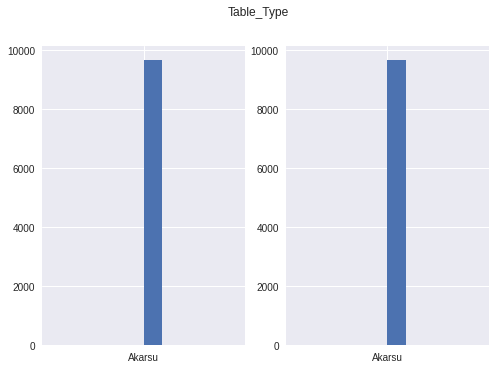

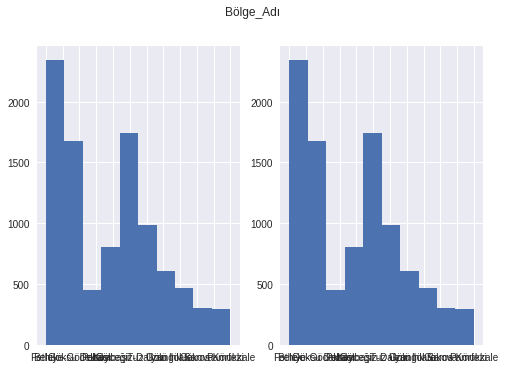

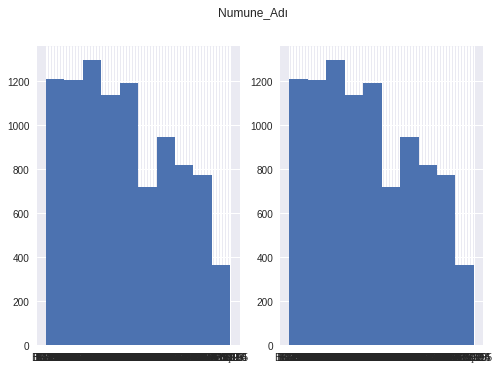

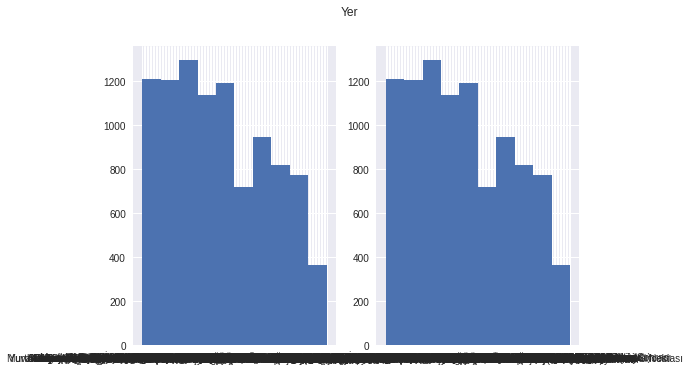

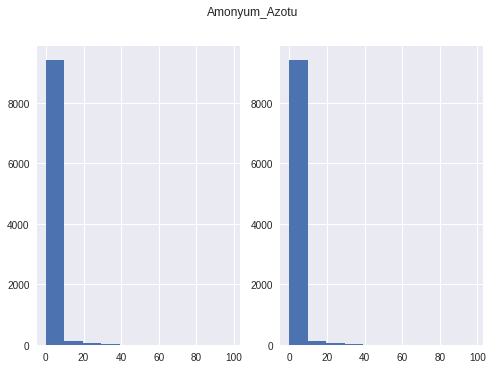

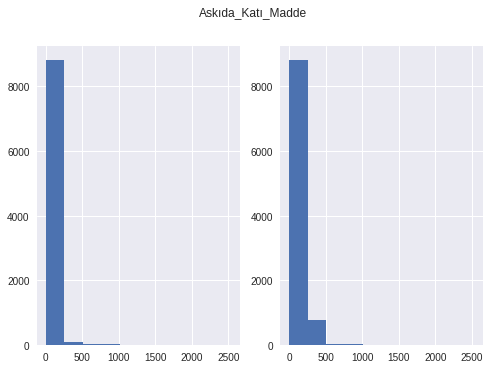

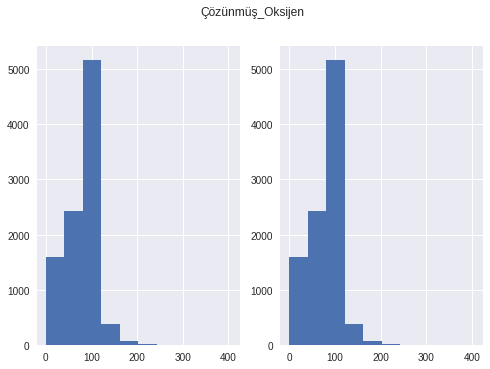

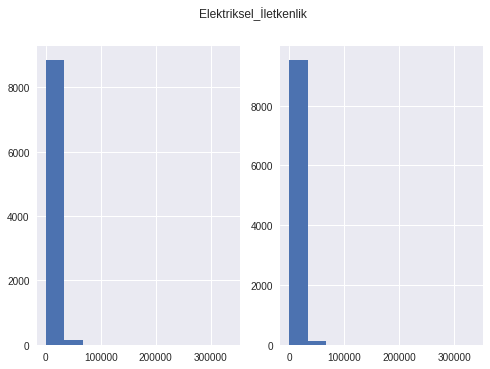

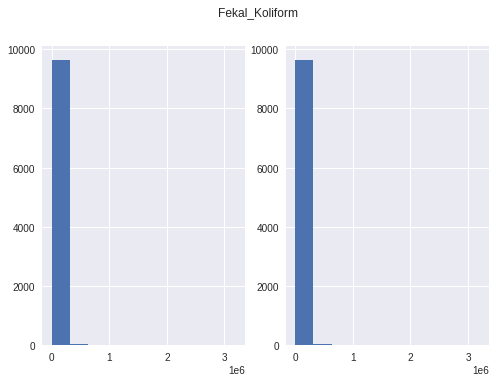

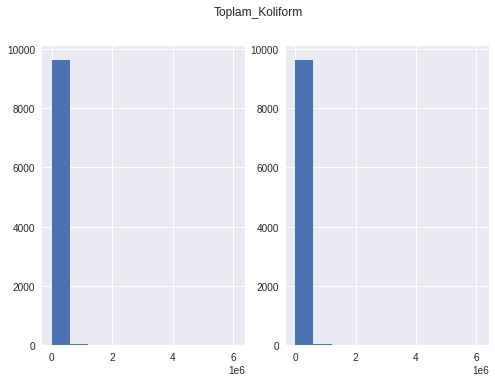

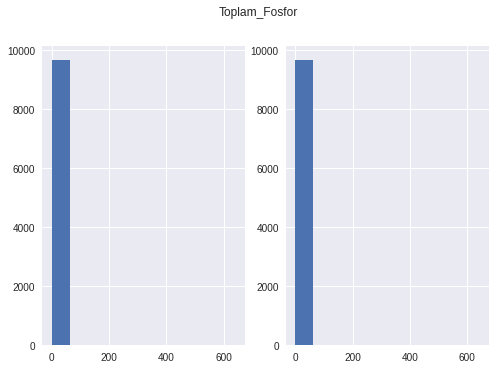

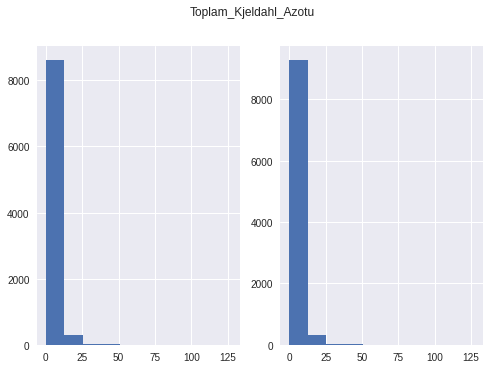

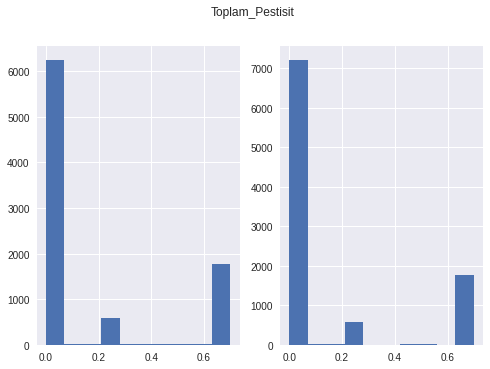

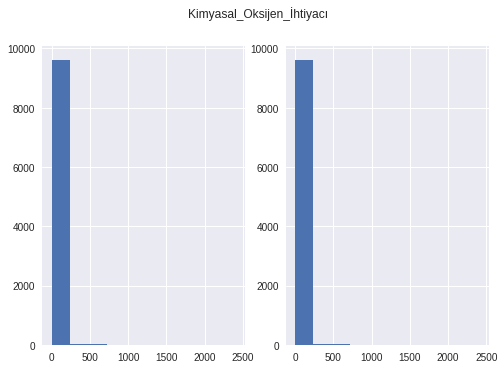

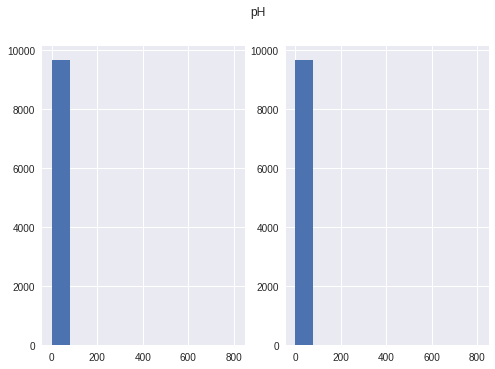

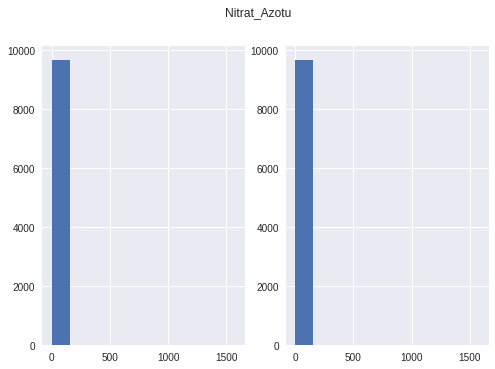

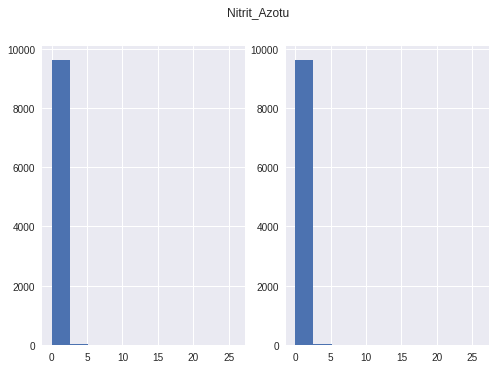

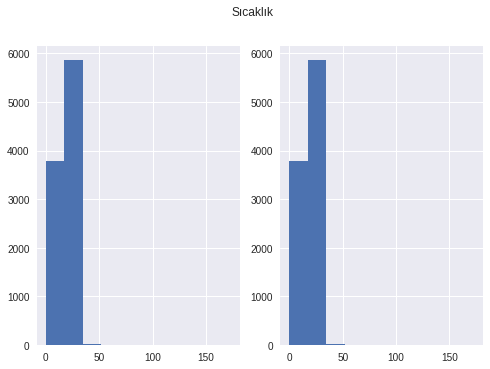

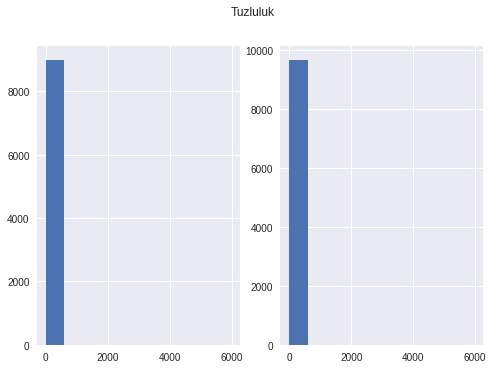

In [ ]:
new_Akarsu = wqms_EDA(akarsu)


In [ ]:
print(new_Akarsu.shape)
print(new_Akarsu.tail(5))
new_Akarsu.to_csv("yeni_akarsu_relevant.csv")
!cp yeni_akarsu_relevant.csv "drive/My Drive/"
    
    
akarsu_acısu = new_Akarsu.loc[new_Akarsu['Yer'] == 'Acısu Deresi']
akarsu_acısu = pd.DataFrame(akarsu_acısu)
akarsu_acısu.drop([ 'Table_Type', 'Bölge_Adı', 'Numune_Adı', 'Yer'], axis=1, inplace=True)
print(akarsu_acısu.describe())


(9662, 19)
           Table_Type      Bölge_Adı Numune_Adı  \
Date                                              
2020-12-01     Akarsu  Göksu Deltası        A50   
2020-08-01     Akarsu  Göksu Deltası        A51   
2020-09-01     Akarsu  Göksu Deltası        A51   
2020-10-01     Akarsu  Göksu Deltası        A51   
2020-11-01     Akarsu  Göksu Deltası        A51   

                                                    Yer  Amonyum_Azotu  \
Date                                                                     
2020-12-01   Silifke Atıksu Arıtma Tesisi Deşarj Öncesi           0.10   
2020-08-01  Silifke Atıksu Arıtma Tesisi Deşarj Sonrası           0.10   
2020-09-01  Silifke Atıksu Arıtma Tesisi Deşarj Sonrası           0.10   
2020-10-01  Silifke Atıksu Arıtma Tesisi Deşarj Sonrası           0.10   
2020-11-01  Silifke Atıksu Arıtma Tesisi Deşarj Sonrası           0.10   

            Askıda_Katı_Madde  Çözünmüş_Oksijen  Elektriksel_İletkenlik  \
Date                                 

'timeseries = akarsu_acısu.assign()\n    # timeseries = pd.DataFrame(timeseries)\n    print(akarsu_acısu.head(5))\n    akarsu_acısu.drop([ \'Table_Type\', \'Year\', \'Month\', \'Bölge_Adı\', \'Numune_Adı\', \'Yer\'], axis=1, inplace=True)\n    akarsu_acısu = pd.DataFrame(akarsu_acısu)\n    print("shape\n", akarsu_acısu.shape)\n    #akarsu_acısu.astype(\'float\n\n    return (akarsu_acısu, akarsu_rel)'

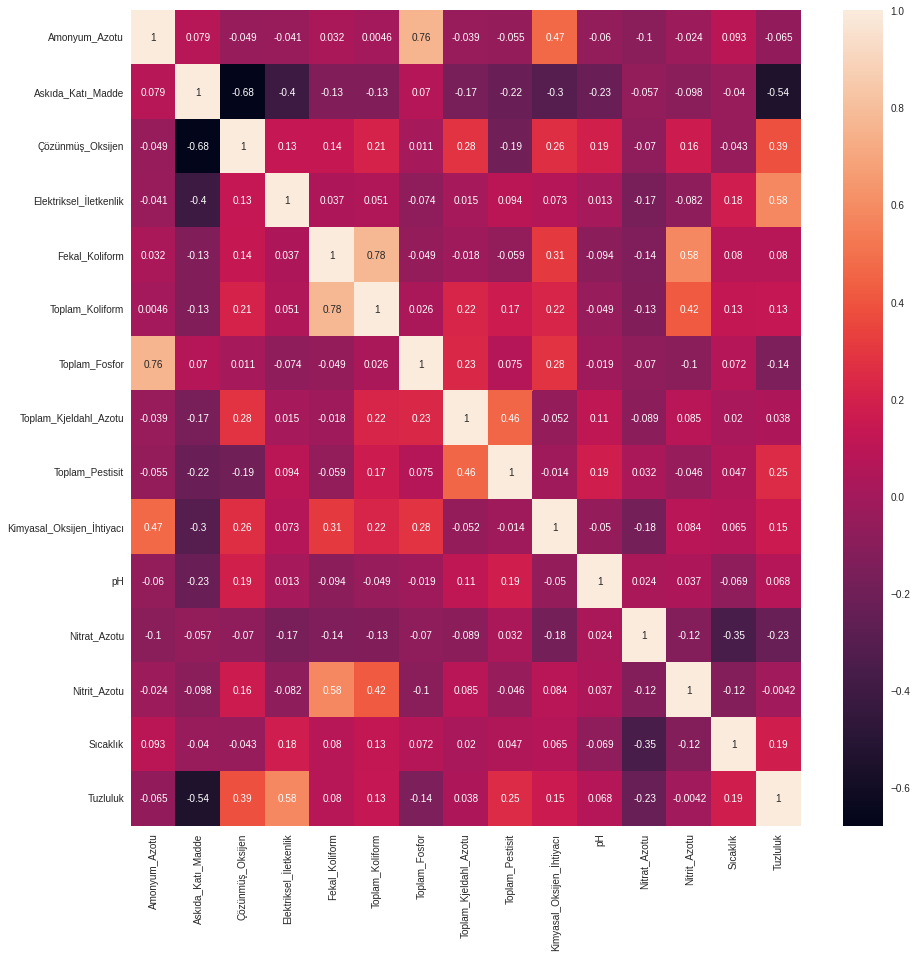

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(akarsu_acısu.corr(), ax=ax, annot=True)
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

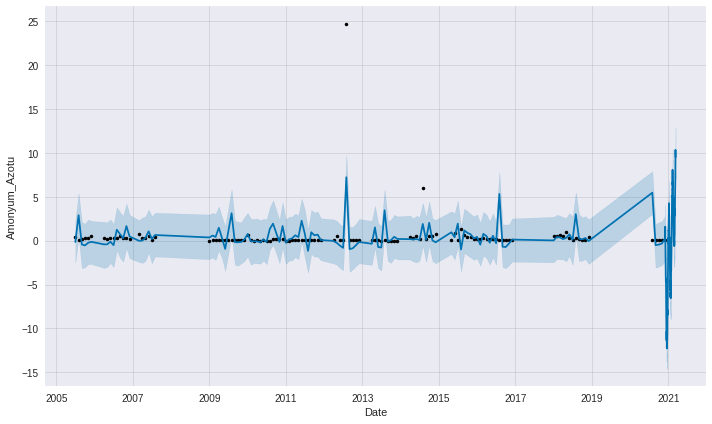

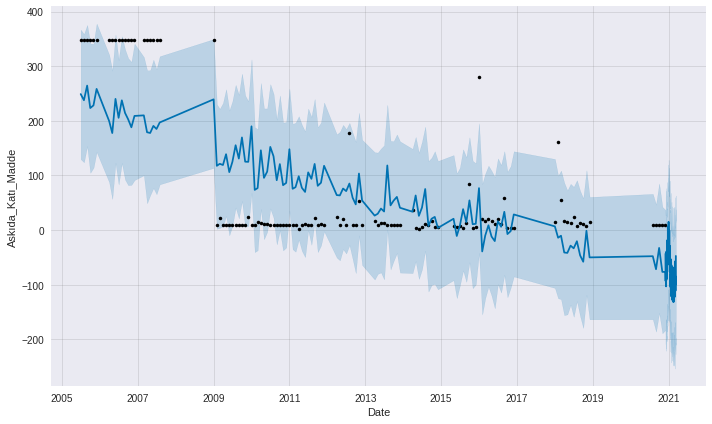

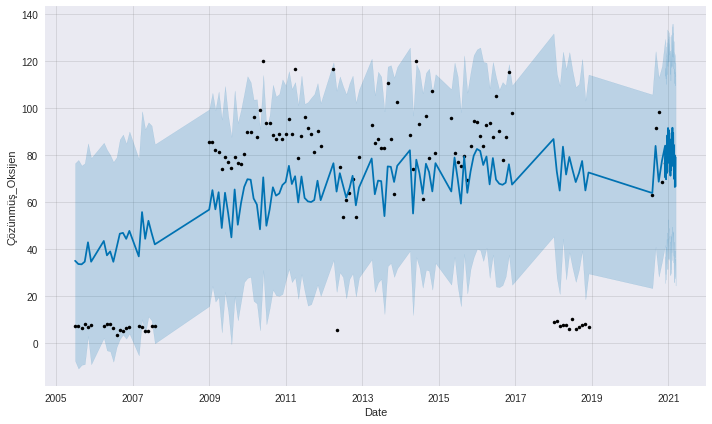

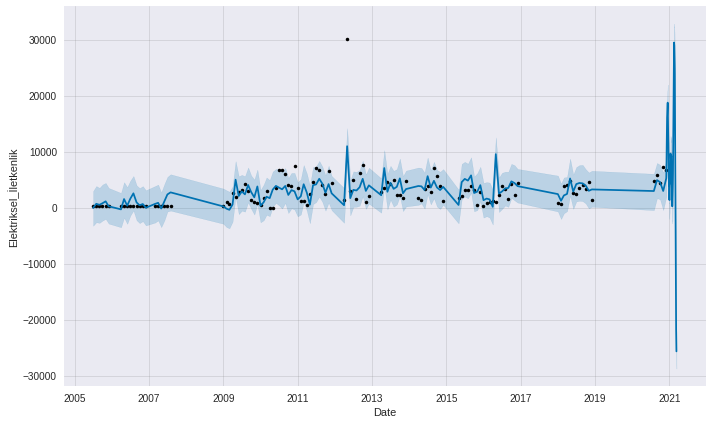

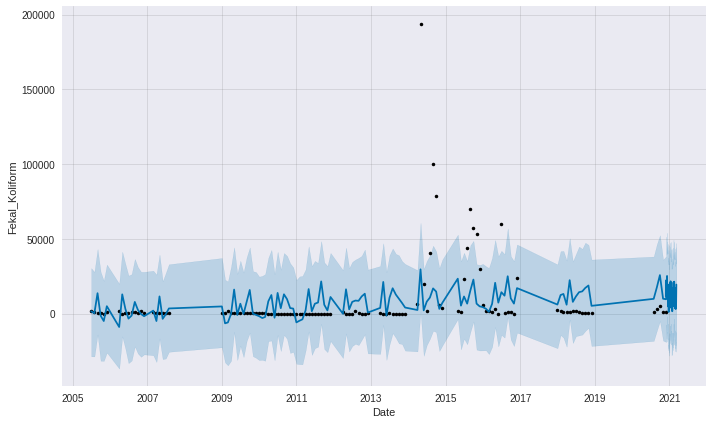

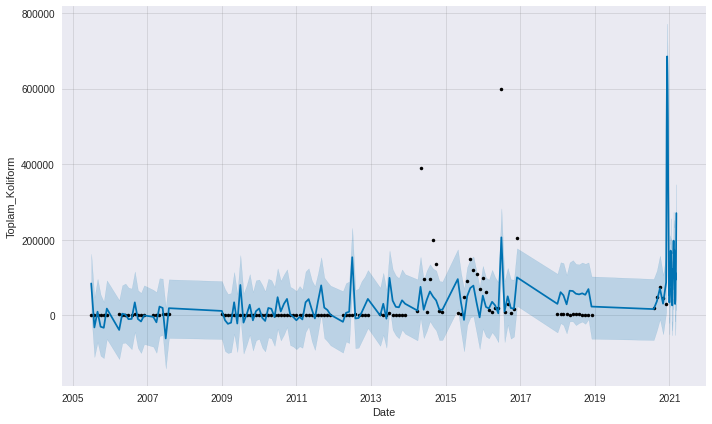

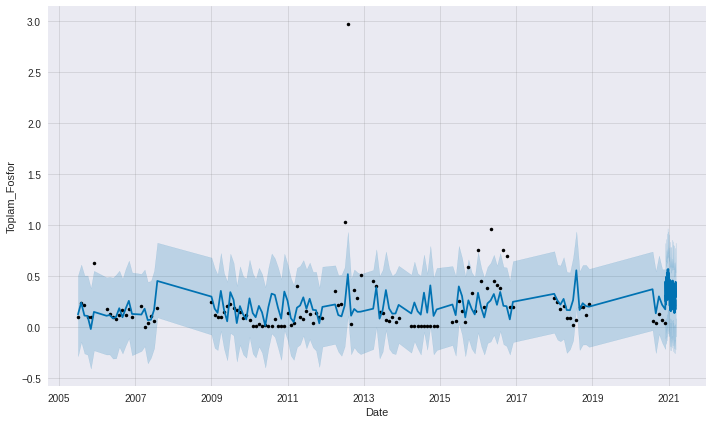

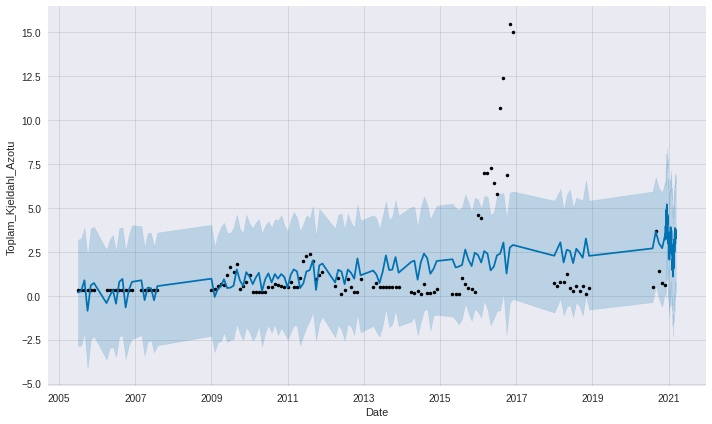

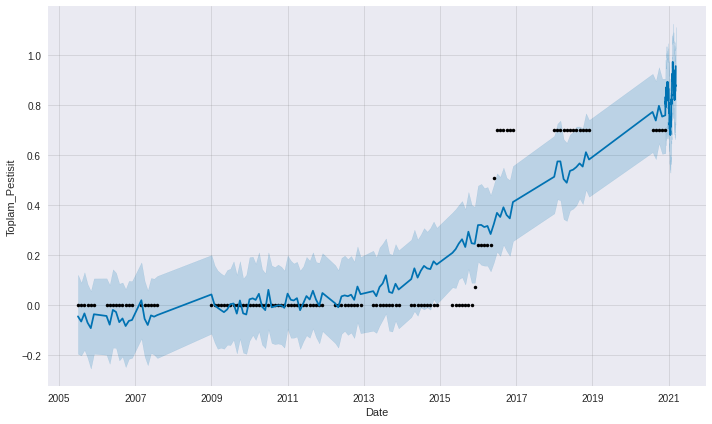

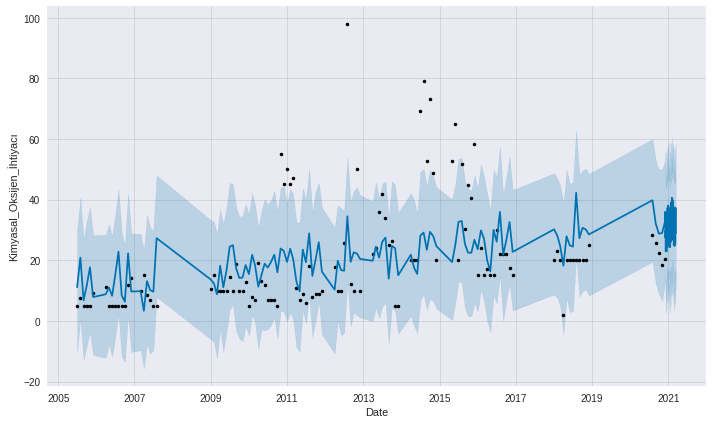

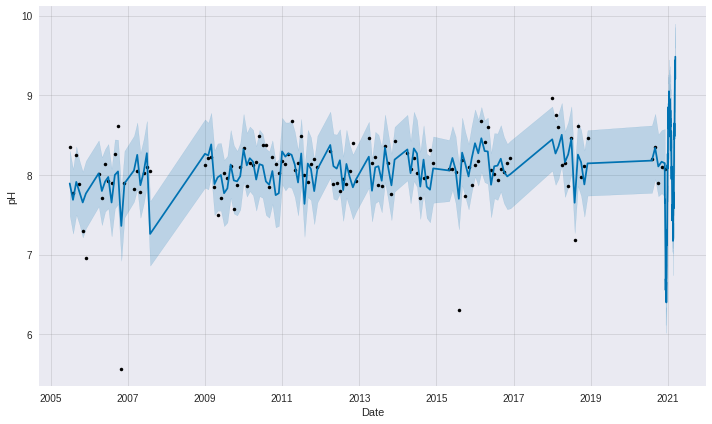

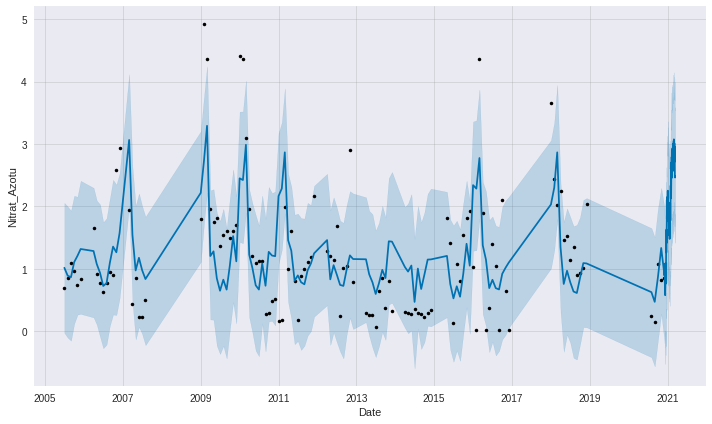

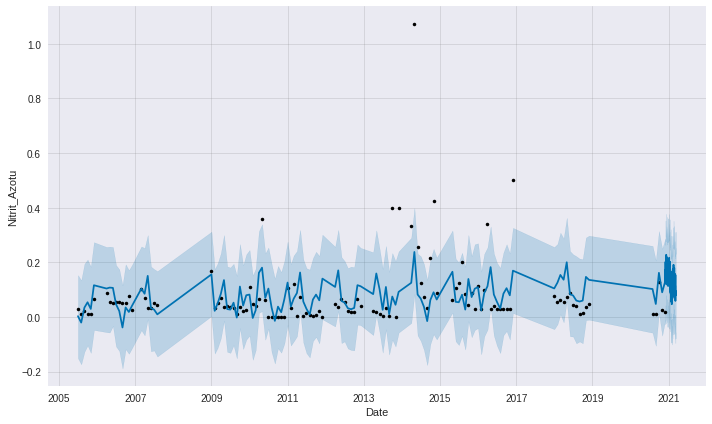

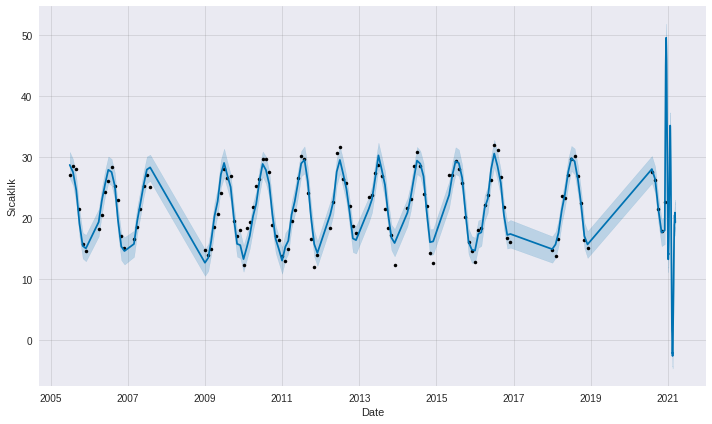

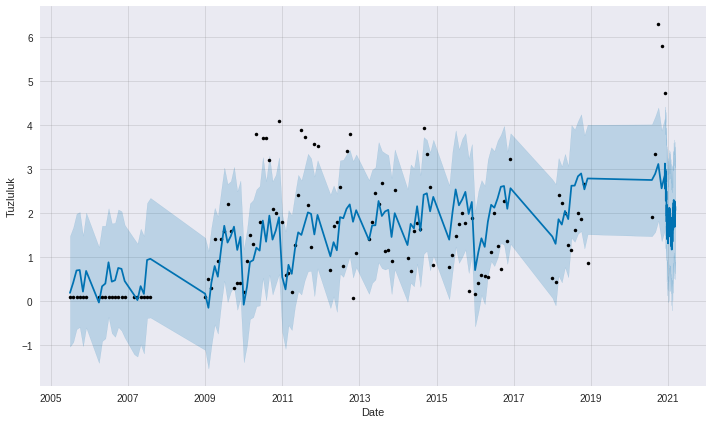

In [ ]:

frlist = []
akarsu = akarsu_acısu.copy()
akarsu = pd.DataFrame(akarsu)
akarsu['Date']=pd.to_datetime(akarsu_acısu.index)
f = pd.DataFrame()

for i in akarsu.columns.drop('Date'):
  f['ds'] = akarsu['Date']
  f['y']= akarsu[i]
  m = Prophet(weekly_seasonality=True)
  m.fit(f)
  #forecast
  future= m.make_future_dataframe(periods=100)
  #1000 gün içinde ver
  forecast = m.predict(future)
  frlist.append(forecast)
  fig1 = m.plot(forecast, xlabel='Date', ylabel=i)







  

In [ ]:
for i in range(len(akarsu.columns.drop('Date'))):
  print(frlist[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


            ds  yhat  yhat_lower  yhat_upper
0   2005-07-01 -0.15       -2.52        2.28
1   2005-08-01  2.90        0.40        5.38
2   2005-09-01 -0.44       -3.13        2.10
3   2005-10-01 -0.55       -3.04        1.94
4   2005-11-01 -0.24       -2.66        2.40
..         ...   ...         ...         ...
216 2021-03-07  5.92        3.47        8.53
217 2021-03-08  6.53        4.05        8.82
218 2021-03-09  7.94        5.31       10.38
219 2021-03-10 10.33        7.87       12.92
220 2021-03-11  9.49        7.00       11.93

[221 rows x 4 columns]
            ds    yhat  yhat_lower  yhat_upper
0   2005-07-01  249.10      130.00      366.98
1   2005-08-01  237.82      124.23      358.75
2   2005-09-01  264.61      153.80      375.64
3   2005-10-01  223.51      105.00      341.61
4   2005-11-01  228.38      114.29      340.99
..         ...     ...         ...         ...
216 2021-03-07  -92.69     -205.56       28.52
217 2021-03-08 -110.98     -227.02       14.83
218 2021-03-0

# check whether stationary


In [ ]:

#There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

#Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
#Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
#Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

In [ ]:
#summary statistics- veriyi iki parçaya böleriz, Running this example shows that the mean and variance values are different, but in the same ball-park.
#Eğer mean variance yakınsa stationary değilse non-stationary

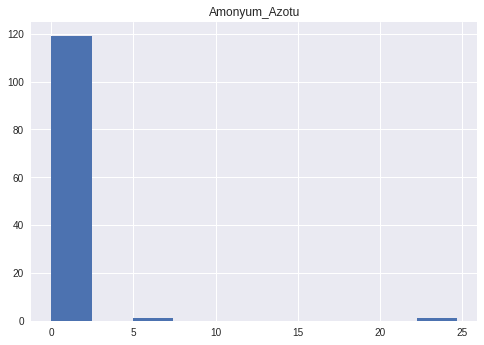


 **** DEĞER****** Amonyum_Azotu
mean1=0.241800, mean2=0.103033, , mean3=1.287251 , mean4=0.225580
variance1=0.035247, variance2=0.020598 , var3=20.051076, var4=0.044881


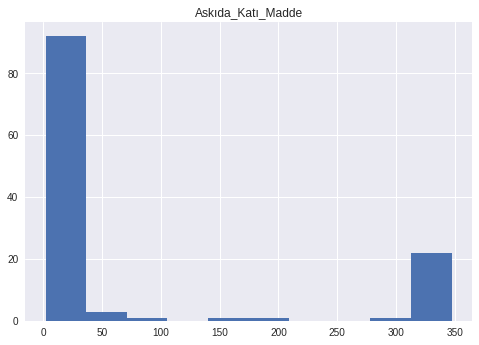


 **** DEĞER****** Askıda_Katı_Madde
mean1=257.843310, mean2=11.763280, , mean3=19.747998 , mean4=28.522561
variance1=22060.659355, variance2=21.107844 , var3=1114.027202, var4=2927.796084


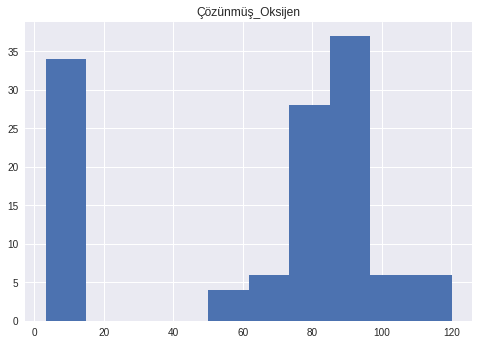


 **** DEĞER****** Çözünmüş_Oksijen
mean1=28.556000, mean2=87.909000, , mean3=81.730999 , mean4=57.454194
variance1=1130.650204, variance2=349.323349 , var3=256.995336, var4=1652.892908


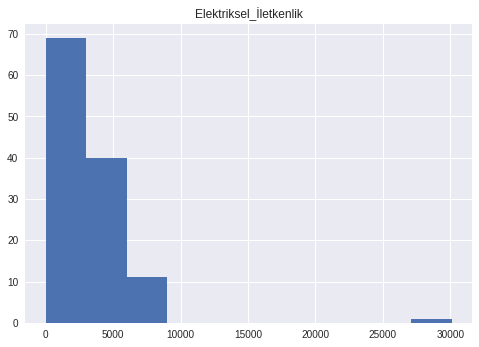


 **** DEĞER****** Elektriksel_İletkenlik
mean1=852.433333, mean2=4191.585333, , mean3=3399.123210 , mean4=3040.983871
variance1=1210971.045556, variance2=28422750.630538 , var3=2885975.775733, var4=3332310.249740


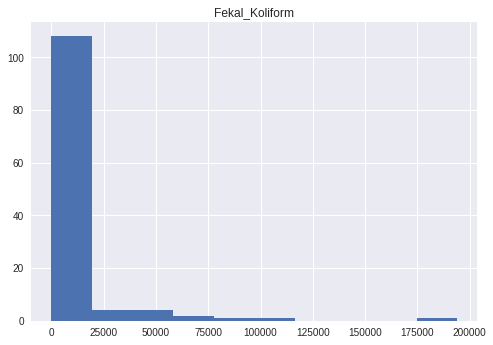


 **** DEĞER****** Fekal_Koliform
mean1=623.333333, mean2=87.873333, , mean3=21741.298258 , mean4=6687.580645
variance1=311288.888889, variance2=25947.571956 , var3=1747228017.028817, var4=213240965.920916


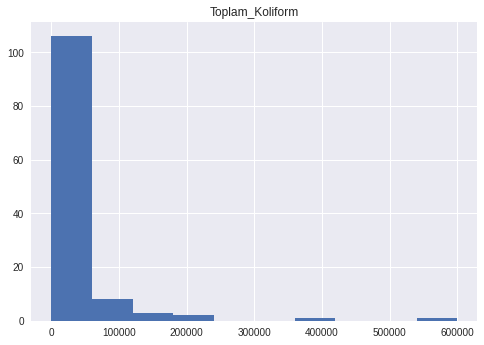


 **** DEĞER****** Toplam_Koliform
mean1=1666.666667, mean2=201.266667, , mean3=46895.603532 , mean4=49120.000000
variance1=740222.222222, variance2=89567.528889 , var3=7037285387.927336, var4=12015390754.838709


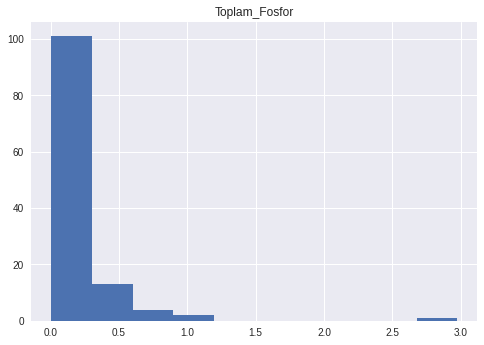


 **** DEĞER****** Toplam_Fosfor
mean1=0.156267, mean2=0.096533, , mean3=0.265980 , mean4=0.278893
variance1=0.011360, variance2=0.009476 , var3=0.305268, var4=0.054828


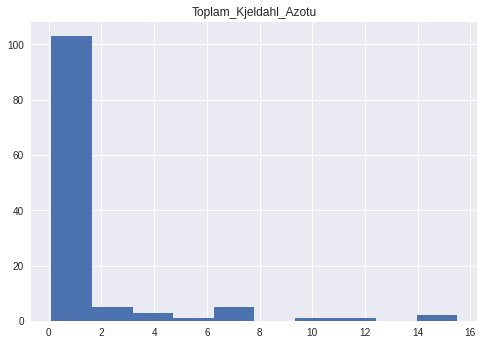


 **** DEĞER****** Toplam_Kjeldahl_Azotu
mean1=0.493600, mean2=0.816432, , mean3=0.420431 , mean4=3.785903
variance1=0.168672, variance2=0.378655 , var3=0.069816, var4=20.229576


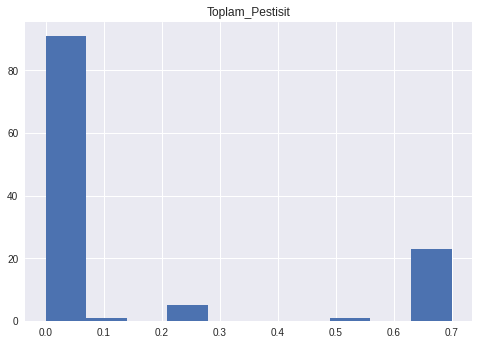


 **** DEĞER****** Toplam_Pestisit
mean1=0.000099, mean2=0.000160, , mean3=0.000439 , mean4=0.576759
variance1=0.000000, variance2=0.000000 , var3=0.000000, var4=0.048675


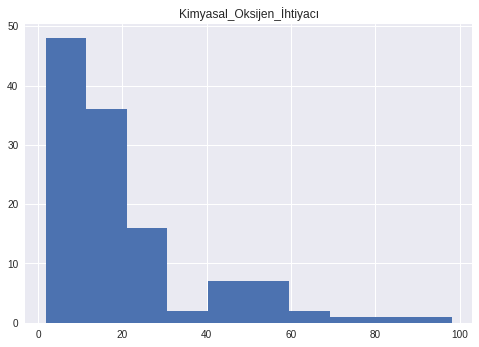


 **** DEĞER****** Kimyasal_Oksijen_İhtiyacı
mean1=8.793297, mean2=16.313318, , mean3=36.436834 , mean4=21.740724
variance1=14.901700, variance2=219.861362 , var3=537.071425, var4=82.457899


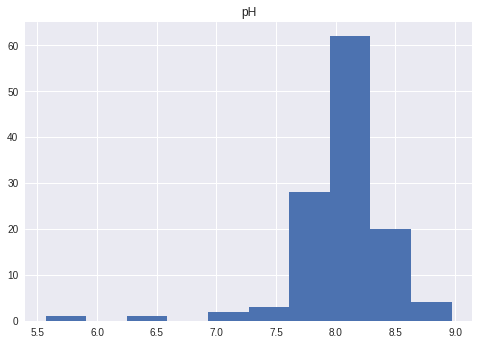


 **** DEĞER****** pH
mean1=7.870667, mean2=8.135333, , mean3=8.014478 , mean4=8.204839
variance1=0.278586, variance2=0.050478 , var3=0.142693, var4=0.110669


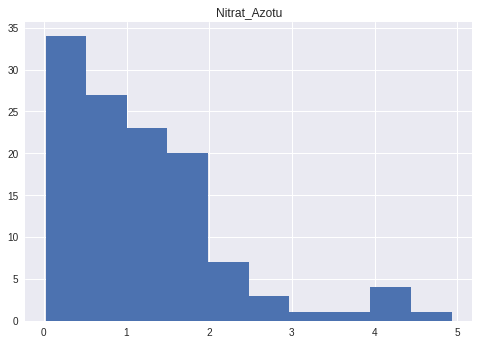


 **** DEĞER****** Nitrat_Azotu
mean1=1.420900, mean2=1.355170, , mean3=0.701917 , mean4=1.309564
variance1=1.162696, variance2=1.071442 , var3=0.395729, var4=1.007826


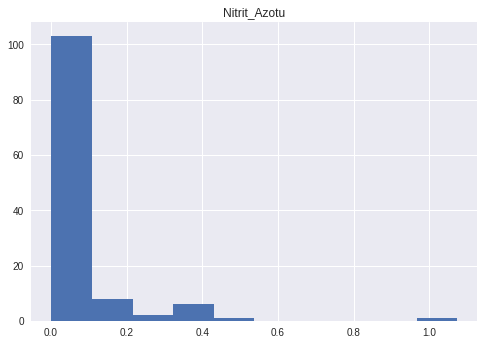


 **** DEĞER****** Nitrit_Azotu
mean1=0.048567, mean2=0.043767, , mean3=0.144973 , mean4=0.071390
variance1=0.000995, variance2=0.004639 , var3=0.045567, var4=0.009685


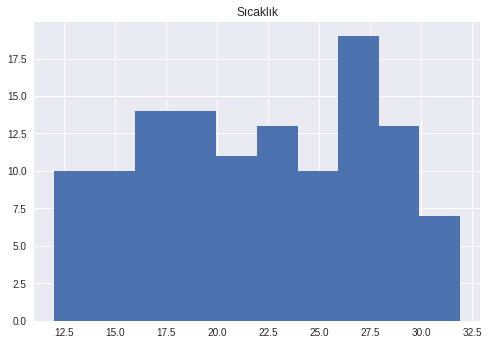


 **** DEĞER****** Sıcaklık
mean1=21.836667, mean2=20.790000, , mean3=23.481571 , mean4=21.656452
variance1=23.872989, variance2=33.542900 , var3=26.924843, var4=31.212378


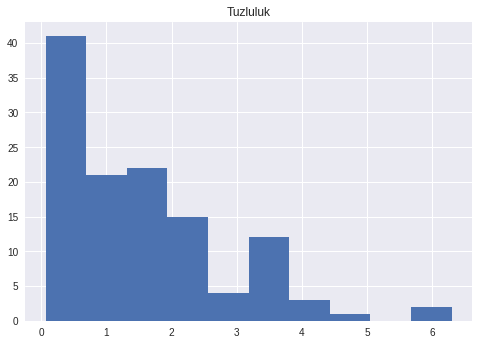


 **** DEĞER****** Tuzluluk
mean1=0.403333, mean2=1.952667, , mean3=1.804005 , mean4=1.855323
variance1=0.345656, variance2=1.649673 , var3=0.926320, var4=2.244840


In [ ]:
for i in akarsu.columns.drop('Date'):
    X = akarsu[i].values
    plt.figure
    plt.hist(X)
    plt.title('%s'%i)
    plt.show()
    split = int(len(X) / 4)
    X1, X2 , X3, X4 = X[0:split],X[split:split*2],X[split*2:split*3], X[split*3:]
    mean1, mean2, mean3 , mean4 = X1.mean(), X2.mean(),X3.mean(), X4.mean()
    var1, var2, var3, var4= X1.var(), X2.var(),X3.var(), X4.var()
    print('\n **** DEĞER****** %s' % i)
    print('mean1=%f, mean2=%f, , mean3=%f , mean4=%f' % (mean1, mean2, mean3 , mean4))
    print('variance1=%f, variance2=%f , var3=%f, var4=%f' % (var1, var2, var3, var4))

#Running the example shows that indeed the distribution of values does not look like a Gaussian, therefore the mean and variance values are less meaningful.


Augmented Dickey-Fuller test


There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.


Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [ ]:
from statsmodels.tsa.stattools import adfuller

for i in akarsu.columns.drop('Date'):
    X = akarsu[i].values
    result = adfuller(X)
    print('\n ***** Fuller Test for %s' %i) 
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))



 ***** Fuller Test for Amonyum_Azotu
ADF Statistic: -11.054107
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580

 ***** Fuller Test for Askıda_Katı_Madde
ADF Statistic: -2.190562
p-value: 0.209689
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580

 ***** Fuller Test for Çözünmüş_Oksijen
ADF Statistic: -2.643008
p-value: 0.084430
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580

 ***** Fuller Test for Elektriksel_İletkenlik
ADF Statistic: -5.441413
p-value: 0.000003
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580

 ***** Fuller Test for Fekal_Koliform
ADF Statistic: -3.378560
p-value: 0.011712
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580

 ***** Fuller Test for Toplam_Koliform
ADF Statistic: -2.939767
p-value: 0.040915
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580

 ***** Fuller Test for Toplam_Fosfor
ADF Statistic: -3.376527
p-value: 0.011786
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580

 ***** Fuller Test for Toplam_Kjel

the ADF statistic value of -4.651. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).  that the time series is stationary or does not have time-dependent structure.

#ARIMA

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.5 MB/s 
     |████████████████████████████████| 9.5 MB 47.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


96


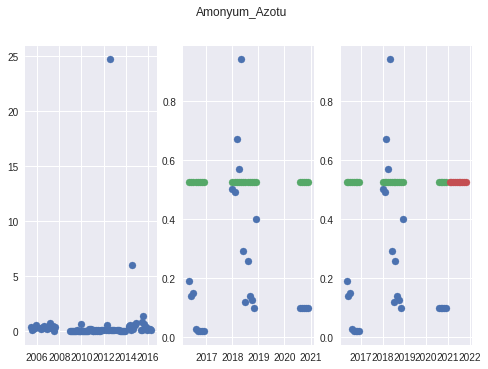

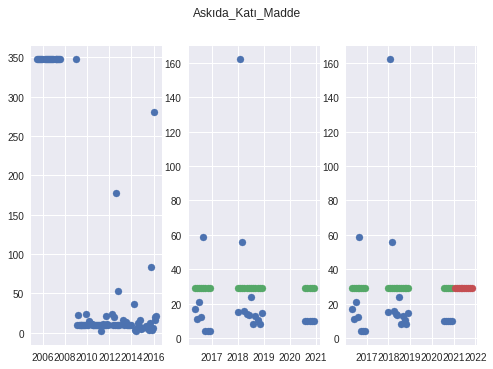

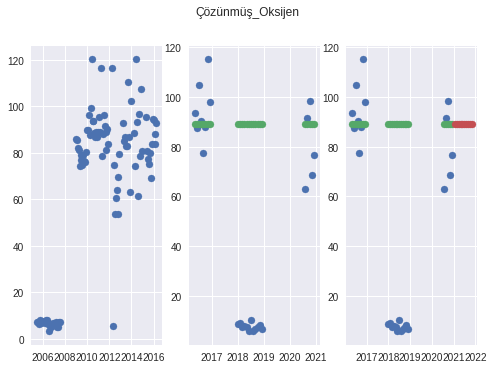

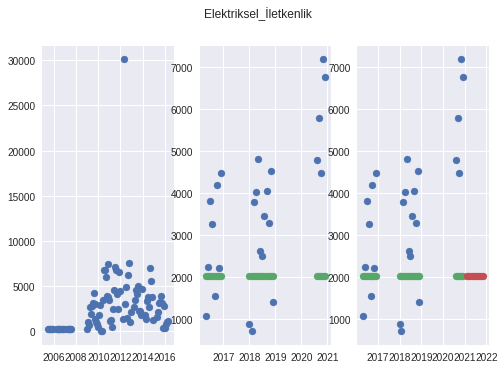

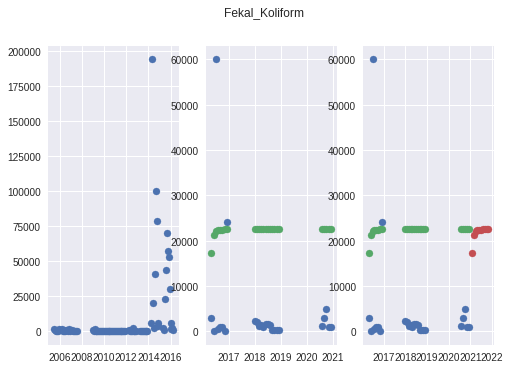

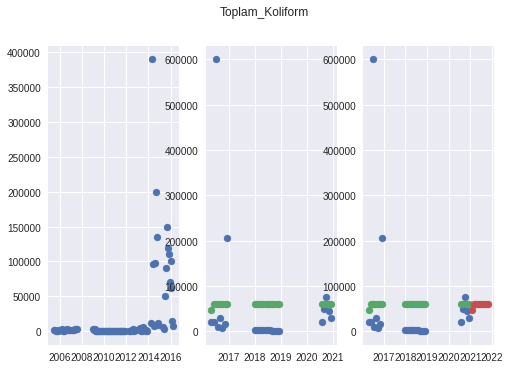

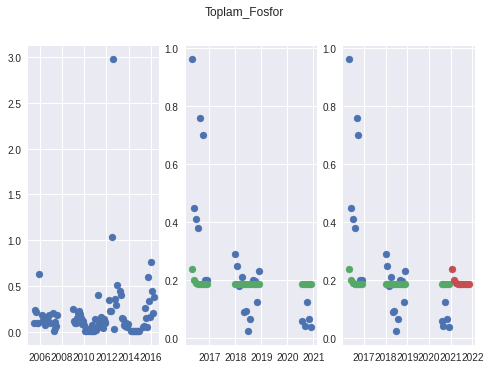

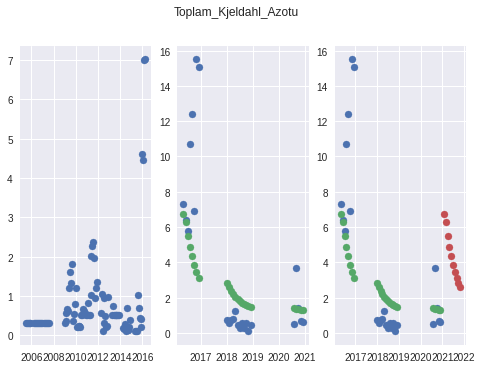

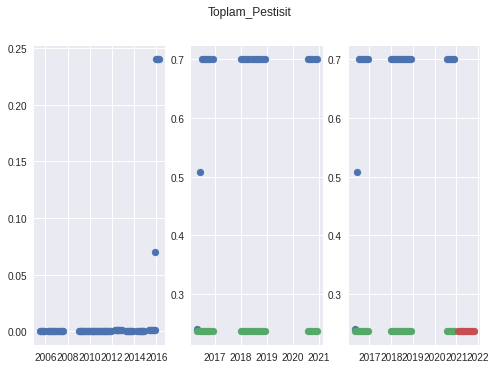

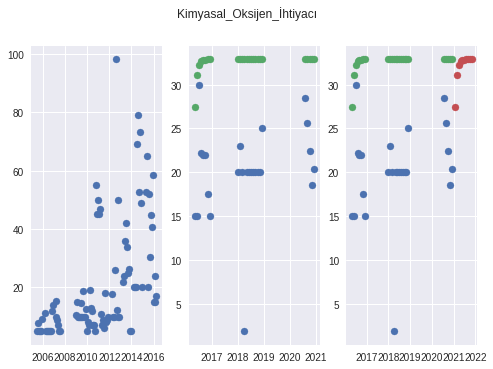

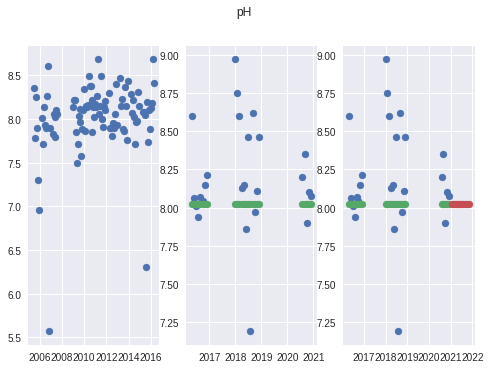

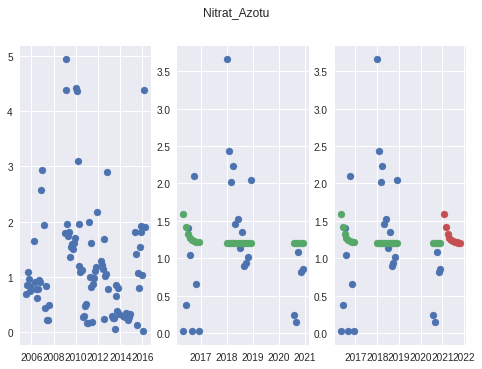

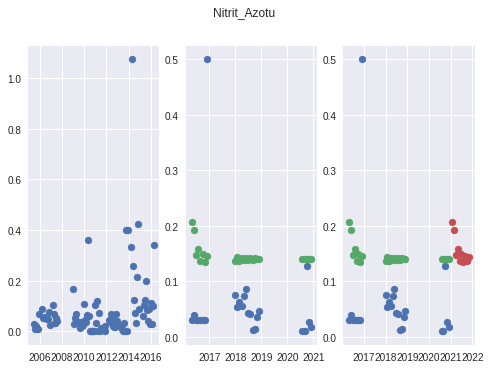

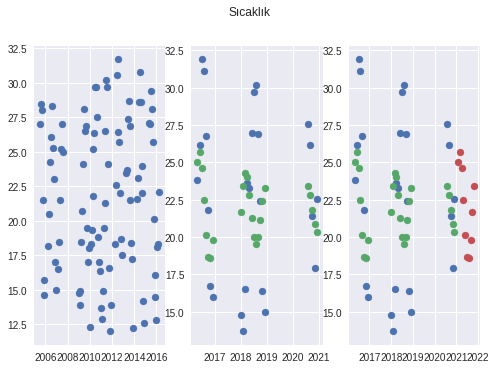

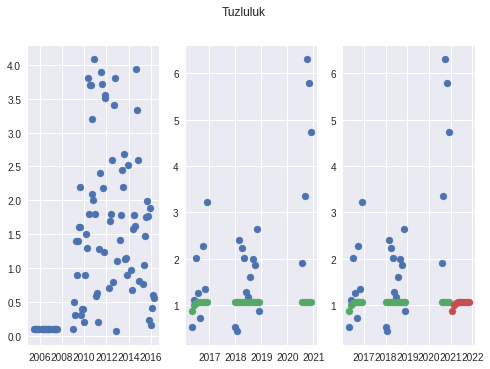

In [ ]:
from pmdarima import auto_arima
from matplotlib.dates import num2date
print(int(akarsu.shape[0] *0.8))

split = int(akarsu.shape[0] *0.8)
train = akarsu_acısu[:split]
test = akarsu_acısu[split:]

for i in akarsu.columns.drop('Date'):
      
    train_df = train[i]
    test_df = test[i]
   

    model = auto_arima(train_df, trace=False, error_action='ignore', suppress_warnings=True)
    model.fit(train_df)

   
    forecast = model.predict(n_periods=len(test_df))
    forecast = pd.DataFrame(forecast,index =test_df.index,columns=['Prediction'])

    forecast_new = model.predict(start=pd.to_datetime('2021-01'), dynamic=False)
    forecast_new = pd.DataFrame(forecast_new,index = pd.date_range(start='2021-01',end='2021-11',freq='M'),columns=['Prediction'])
    
    #print(test_df)
    #print(forecast)
    #print(forecast_new)
    fig, axs = plt.subplots(1,3)
    fig.suptitle(i)
    axs[0].scatter(train_df.index,train_df, label='Train')
    axs[1].scatter(test_df.index, test_df, label='Valid')
    axs[1].scatter(forecast.index,forecast,  label='Prediction')
    axs[2].scatter(test_df.index, test_df)
    axs[2].scatter(forecast.index,forecast)
    axs[2].scatter(forecast_new.index,forecast_new)
    
    
    plt.show()

#LSTM_Seq

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [ ]:
akarsu.shape

(121, 16)

In [ ]:
scaler = MinMaxScaler()
akarsu_scaled = akarsu.copy()
for column in akarsu:
  values = akarsu[column].values
  values = values.reshape((len(values), 1))
  akarsu_scaled[column] = scaler.fit_transform(values)

akarsu_scaled.index = pd.to_datetime(akarsu_scaled.index, yearfirst = True)
akarsu.index = pd.to_datetime(akarsu.index, yearfirst = True)
df = akarsu_scaled
df.describe()

,Amonyum_Azotu,Askıda_Katı_Madde,Çözünmüş_Oksijen,Elektriksel_İletkenlik,Fekal_Koliform,Toplam_Koliform,Toplam_Fosfor,Toplam_Kjeldahl_Azotu,Toplam_Pestisit,Kimyasal_Oksijen_İhtiyacı,pH,Nitrat_Azotu,Nitrit_Azotu,Sıcaklık,Tuzluluk,Date
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,0.02,0.22,0.52,0.10,0.04,0.04,0.07,0.08,0.21,0.20,0.73,0.24,0.07,0.50,0.23,0.46
std,0.09,0.38,0.32,0.11,0.12,0.12,0.11,0.18,0.39,0.18,0.12,0.20,0.12,0.28,0.21,0.27
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.02,0.04,0.03,0.00,0.00,0.02,0.01,0.00,0.07,0.69,0.07,0.02,0.25,0.05,0.28
50%,0.00,0.03,0.65,0.08,0.00,0.00,0.04,0.03,0.00,0.14,0.74,0.20,0.04,0.50,0.19,0.45
75%,0.01,0.06,0.74,0.13,0.01,0.01,0.07,0.06,0.00,0.23,0.78,0.32,0.07,0.75,0.34,0.67
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
split = int(akarsu_scaled.shape[0] *0.8)
#akarsu_acısu.set_index(akarsu_acısu['Tarih'])
#akarsu_acısu.index = num2date(akarsu_acısu.index) #bunu düzelt
train = akarsu_scaled[:split]
train_Y = train['Fekal_Koliform'].values
test_X = test.values
test_Y = test['Fekal_Koliform'].values

timesteps = train_X.shape[0]
train_X = train_X.reshape(train_X.shape[0],1, train_X.shape[1])
test_X  = test_X.reshape( test_X.shape[0], 1, test_X.shape[1])
train_Y = train_Y.reshape( train_Y.shape[0],1)
test_Y = test_Y.reshape(test_Y.shape[0], 1)

print(train_X.shape)


model_gru = create_gru(4)
model_bilstm = create_bilstm(8)
#history_gru = fit_model(model_gru)
#history_bilstm = fit_model(model_bilstm)
model_gru.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

# model.summary()
history_gru = fit_model(model_gru)
   


In [ ]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(train_X.shape[0], train_X.shape[1])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units,input_shape=(train_X.shape[0], train_X.shape[1]))))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model


In [ ]:
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = ( train_X.shape[1],1)))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units,input_shape=( train_X.shape[1],1))) 
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model


In [ ]:
def fit_model(model):
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 2)
  history = model.fit(train_X, train_Y, epochs = 4,  
                      validation_split = 0.2,
                      batch_size = 2, shuffle = False, 
                      callbacks = [early_stop])
  return history
#history_gru = fit_model(model_gru)
#history_bilstm = fit_model(model_bilstm)

In [ ]:
from numpy import array
timesteps = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)


X = seq.reshape(1, 5, 1)
y = seq.reshape(1, 5)
n_neurons = length
n_batch = 1
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:]:
	print('%.1f' % value)